# CNN-Transformer Evaluation on New TEP Dataset

This notebook evaluates the trained CNN-Transformer model on the newly generated independent TEP dataset.

**Purpose**: Test model generalization on completely unseen data generated from `tep-sim`.

**Model**: CNN-Transformer (multiclass fault classification)

**Evaluation Dataset**: `data/new_multiclass_eval.csv` (generated by notebook 03)

## Configuration & Imports

In [1]:
import os
import json
import time
import math
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'new_multiclass_eval_quick.csv').exists():
    if not (DATA_DIR / 'new_multiclass_eval.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'new_multiclass_eval_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'new_multiclass_eval.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('CNN-Transformer Evaluation on New TEP Dataset')
if QUICK_MODE:
    print('QUICK MODE - Using limited test dataset')
print(f'Device: {device}')
print('='*60)

CNN-Transformer Evaluation on New TEP Dataset
Device: cuda


## Define Model Architecture

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CNNTransformer(nn.Module):
    """CNN-Transformer: CNN feature extraction + Transformer attention."""
    def __init__(self, input_size, conv_filters, kernel_size, d_model, 
                 nhead, num_encoder_layers, dim_feedforward, dropout, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_size, conv_filters, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm1d(conv_filters)
        self.conv2 = nn.Conv1d(conv_filters, d_model, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm1d(d_model)
        
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)

print('Model class defined')

Model class defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained CNN-Transformer model...')

model_path = MODEL_DIR / 'cnn_transformer_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']

num_classes = len(label_classes)
class_names = [str(int(c)) for c in label_classes]

model = CNNTransformer(
    input_size=len(features),
    conv_filters=config['conv_filters'],
    kernel_size=config['kernel_size'],
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_encoder_layers=config['num_encoder_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    num_classes=num_classes
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Classes: {num_classes}')

orig_metrics_path = METRICS_DIR / 'cnn_transformer_metrics.json'
with open(orig_metrics_path) as f:
    orig_metrics = json.load(f)
print('Original metrics loaded for comparison')


[Step 1/5] Loading trained CNN-Transformer model...


Model loaded from ../outputs/models/cnn_transformer_final.pt
  Features: 52
  Classes: 18
Original metrics loaded for comparison


## Load New Evaluation Dataset

In [4]:
print('\n[Step 2/5] Loading new evaluation dataset...')
start_time = time.time()

eval_file = DATA_DIR / f'new_multiclass_eval{FILE_SUFFIX}.csv'
eval_data = pd.read_csv(eval_file)

print(f'Dataset loaded in {time.time() - start_time:.2f}s')
print(f'  File: {eval_file.name}')
print(f'  Shape: {eval_data.shape}')
print(f'  Unique runs: {eval_data.groupby(["faultNumber", "simulationRun"]).ngroups}')


[Step 2/5] Loading new evaluation dataset...


Dataset loaded in 14.34s
  File: new_multiclass_eval.csv
  Shape: (1978215, 57)
  Unique runs: 2700


## Create Sequence Dataset

In [5]:
class SimulationRunDataset(Dataset):
    def __init__(self, df, features, scaler_mean, scaler_scale, label_classes, sequence_length=10):
        self.sequence_length = sequence_length
        self.features = features
        self.label_classes = label_classes
        self.class_to_idx = {c: i for i, c in enumerate(label_classes)}
        
        self.sequences = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = group[features].values
            X = (X - scaler_mean) / scaler_scale
            
            for i in range(len(X) - sequence_length + 1):
                seq = X[i:i+sequence_length]
                self.sequences.append(seq)
                self.labels.append(self.class_to_idx[fault])
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

print('Dataset class defined')

Dataset class defined


In [6]:
print('\n[Step 3/5] Creating evaluation dataset...')
seq_len = config['sequence_length']

eval_dataset = SimulationRunDataset(
    eval_data, features, scaler_mean, scaler_scale, label_classes, seq_len
)
eval_loader = DataLoader(eval_dataset, batch_size=512, shuffle=False, num_workers=0)

print(f'Evaluation sequences: {len(eval_dataset):,}')


[Step 3/5] Creating evaluation dataset...


Evaluation sequences: 1,875,615


## Generate Predictions

In [7]:
print('\n[Step 4/5] Generating predictions...')
pred_start = time.time()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

y_pred = np.array(all_preds)
y_eval = np.array(all_labels)

print(f'Predictions generated in {time.time() - pred_start:.2f}s')
print(f'  Predictions shape: {y_pred.shape}')


[Step 4/5] Generating predictions...


Predictions generated in 34.82s
  Predictions shape: (1875615,)


## Compute Evaluation Metrics

In [8]:
print('\n[Step 5/5] Computing evaluation metrics...')

accuracy = accuracy_score(y_eval, y_pred)
balanced_acc = balanced_accuracy_score(y_eval, y_pred)
f1_weighted = f1_score(y_eval, y_pred, average='weighted')
f1_macro = f1_score(y_eval, y_pred, average='macro')
precision_weighted = precision_score(y_eval, y_pred, average='weighted')
recall_weighted = recall_score(y_eval, y_pred, average='weighted')
f1_per_class = f1_score(y_eval, y_pred, average=None)
cm = confusion_matrix(y_eval, y_pred)

print('\n' + '='*60)
print('NEW EVALUATION DATASET RESULTS')
if QUICK_MODE:
    print('(Quick mode - limited samples per class)')
print('='*60)
print(f'Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 (weighted):     {f1_weighted:.4f}')
print(f'F1 (macro):        {f1_macro:.4f}')
print('='*60)


[Step 5/5] Computing evaluation metrics...



NEW EVALUATION DATASET RESULTS
Accuracy:          0.9957 (99.57%)
Balanced Accuracy: 0.9944
F1 (weighted):     0.9958
F1 (macro):        0.9953


In [9]:
print('\nComparison with Original Test Set:')
print('-' * 50)
print(f'{"Metric":<20} {"Original":>12} {"New Eval":>12} {"Delta":>10}')
print('-' * 50)

comparisons = [
    ('Accuracy', orig_metrics['accuracy'], accuracy),
    ('Balanced Acc', orig_metrics['balanced_accuracy'], balanced_acc),
    ('F1 (weighted)', orig_metrics['f1_weighted'], f1_weighted),
    ('F1 (macro)', orig_metrics['f1_macro'], f1_macro),
]

for metric_name, orig_val, new_val in comparisons:
    delta = new_val - orig_val
    print(f'{metric_name:<20} {orig_val:>12.4f} {new_val:>12.4f} {delta:>+10.4f}')

print('-' * 50)


Comparison with Original Test Set:
--------------------------------------------------
Metric                   Original     New Eval      Delta
--------------------------------------------------
Accuracy                   0.9920       0.9957    +0.0038
Balanced Acc               0.9920       0.9944    +0.0025
F1 (weighted)              0.9920       0.9958    +0.0038
F1 (macro)                 0.9920       0.9953    +0.0033
--------------------------------------------------


In [10]:
print('\nPer-Class Classification Report:')
print(classification_report(y_eval, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.9405    0.9990    0.9688    114450
           1     0.9997    1.0000    0.9999    114450
           2     0.9999    1.0000    0.9999    114450
           4     0.9995    1.0000    0.9998    114450
           5     0.9986    1.0000    0.9993    114450
           6     1.0000    1.0000    1.0000     12183
           7     1.0000    1.0000    1.0000    114450
           8     0.9992    0.9958    0.9975    114450
          10     0.9995    0.9911    0.9953    114450
          11     1.0000    0.9990    0.9995    114450
          12     0.9999    0.9990    0.9995    104129
          13     0.9981    0.9857    0.9918    112355
          14     1.0000    1.0000    1.0000    114450
          16     0.9999    0.9981    0.9990    114450
          17     0.9998    0.9938    0.9968    114450
          18     0.9995    0.9507    0.9744     44648
          19     0.9997    1.0000    0.9998    114450
          20     0.9999    

## Visualizations

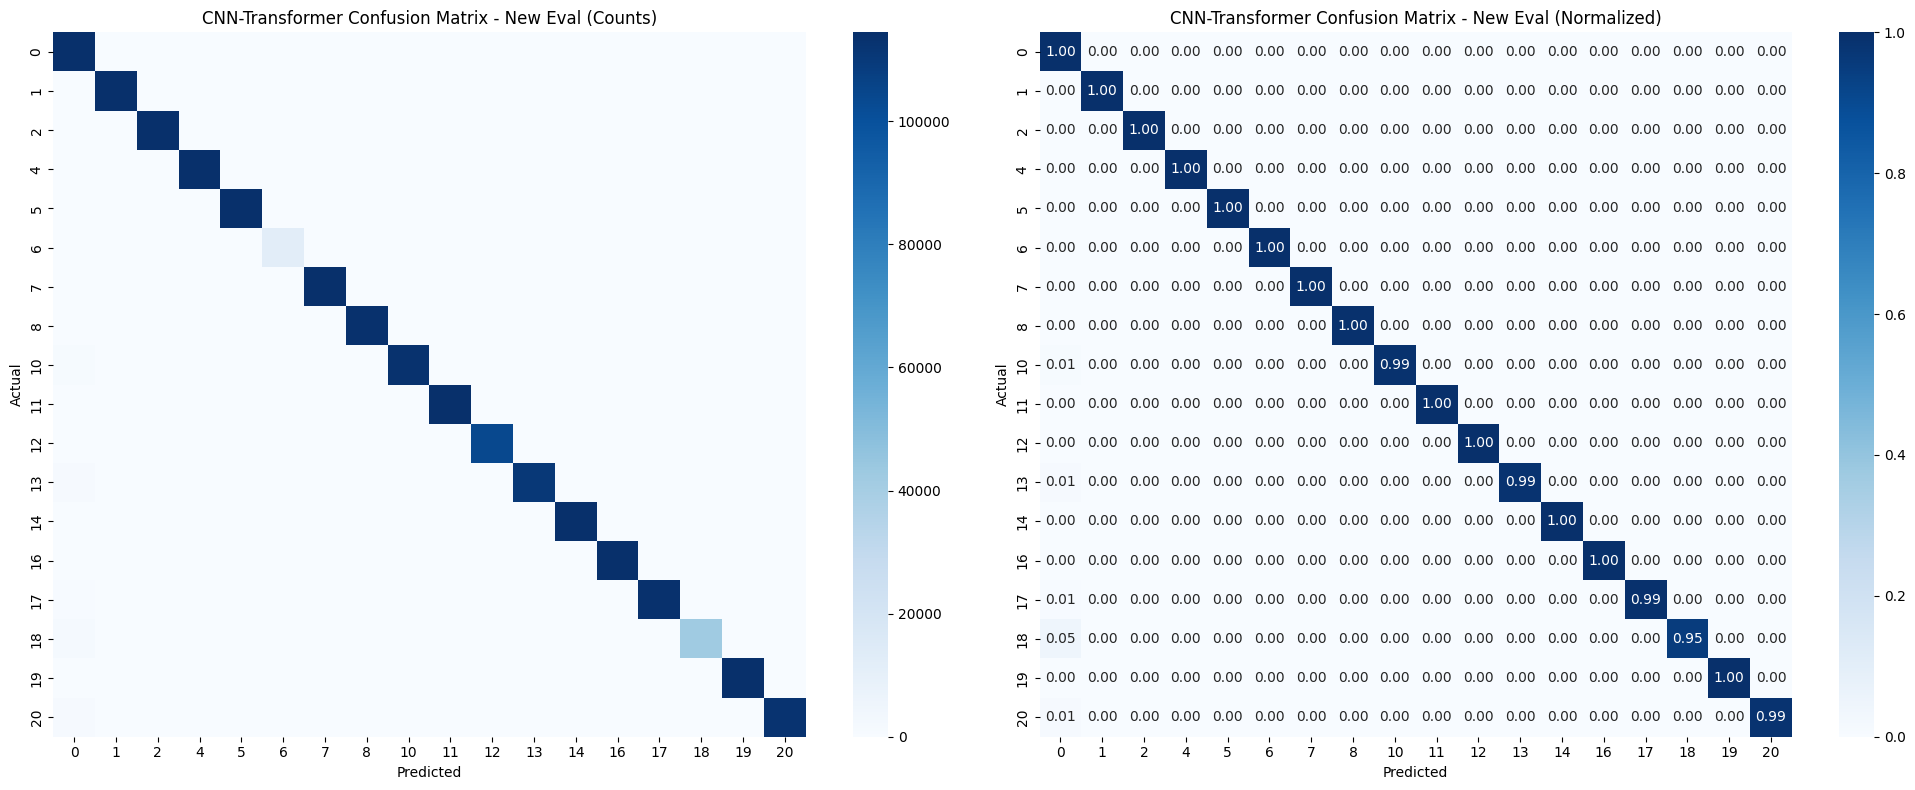

Saved to ../outputs/figures/cnn_transformer_new_eval_confusion_matrix.png


In [11]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('CNN-Transformer Confusion Matrix - New Eval (Counts)')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('CNN-Transformer Confusion Matrix - New Eval (Normalized)')

plt.tight_layout()
output_file = FIGURES_DIR / f'cnn_transformer_new_eval_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

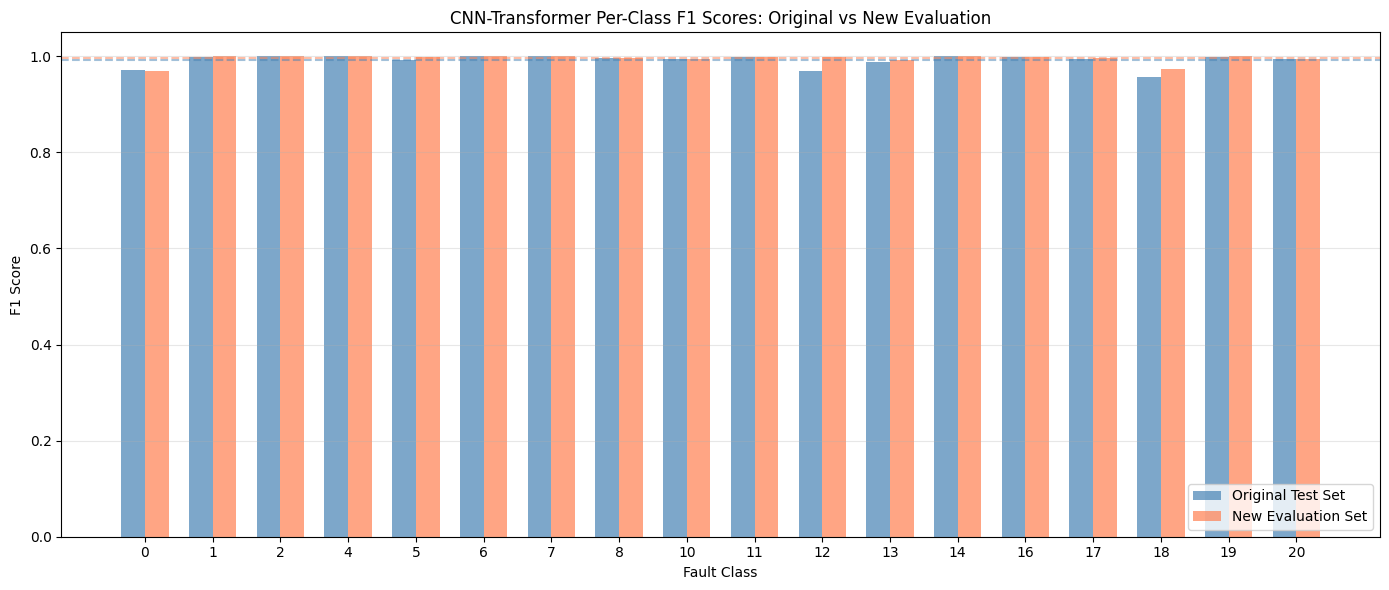

Saved to ../outputs/figures/cnn_transformer_new_eval_per_class_f1.png


In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.35

orig_f1_per_class = [orig_metrics['per_class_f1'][c] for c in class_names]

bars1 = ax.bar(x - width/2, orig_f1_per_class, width, label='Original Test Set', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, f1_per_class, width, label='New Evaluation Set', color='coral', alpha=0.7)

ax.axhline(y=orig_metrics['f1_weighted'], color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(y=f1_weighted, color='coral', linestyle='--', alpha=0.5)

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title('CNN-Transformer Per-Class F1 Scores: Original vs New Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'cnn_transformer_new_eval_per_class_f1{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [13]:
new_eval_metrics = {
    'model': 'CNN-Transformer',
    'dataset': f'new_multiclass_eval{FILE_SUFFIX}',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'num_samples': len(y_eval),
    'num_classes': num_classes,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'comparison_with_original': {
        'accuracy_delta': float(accuracy - orig_metrics['accuracy']),
        'f1_weighted_delta': float(f1_weighted - orig_metrics['f1_weighted']),
        'original_accuracy': orig_metrics['accuracy'],
        'original_f1_weighted': orig_metrics['f1_weighted']
    }
}

output_file = METRICS_DIR / f'cnn_transformer_new_eval_metrics{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(new_eval_metrics, f, indent=2)
print(f'Saved metrics to {output_file}')

Saved metrics to ../outputs/metrics/cnn_transformer_new_eval_metrics.json


In [14]:
print('\n' + '='*60)
print('CNN-Transformer New Data Evaluation Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nSummary:')
print(f'  Evaluation samples: {len(y_eval):,}')
print(f'  Accuracy: {accuracy:.4f} (original: {orig_metrics["accuracy"]:.4f}, delta: {accuracy - orig_metrics["accuracy"]:+.4f})')
print(f'  F1 (weighted): {f1_weighted:.4f} (original: {orig_metrics["f1_weighted"]:.4f}, delta: {f1_weighted - orig_metrics["f1_weighted"]:+.4f})')
print('='*60)


CNN-Transformer New Data Evaluation Complete!

Summary:
  Evaluation samples: 1,875,615
  Accuracy: 0.9957 (original: 0.9920, delta: +0.0038)
  F1 (weighted): 0.9958 (original: 0.9920, delta: +0.0038)
